In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import contractions

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sent_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('../data/political_subreddit.csv')

## Sentiment Scores

In [3]:
def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions (@user)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [4]:
# Apply the normalization function to the 'text' column
df['normalized_text'] = df['text'].apply(normalize_text)

In [5]:
sia = SentimentIntensityAnalyzer()
# Sentiment analysis function
def analyze_text_vader(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0

    sentences = sent_tokenize(text)  # Split text into sentences
    sentiment_scores = [sia.polarity_scores(sentence)['compound'] for sentence in sentences]

    if not sentiment_scores:
        return 0  # Neutral sentiment
    else:
        return np.mean(sentiment_scores)

In [6]:
df['vader_sentiment_avg'] = df['normalized_text'].apply(lambda x: analyze_text_vader(x))

## Logistic Regression

### Vectorizers

In [7]:
def custom_preprocessor(text):
    text = contractions.fix(text.lower())                   # fix contractions and lowercase
    text = re.sub(r'^>.*$', '', text, flags=re.MULTILINE)   # remove quotes
    text = re.sub(r'http\S+|www\S+', '', text)              # remove URLs
    text = re.sub(r'@\w+', '', text)                        # remove mentions
    text = re.sub(r'[^a-z\s]', '', text)                    # remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()                # clean extra whitespace
    return text

In [8]:
count_vectorizer = CountVectorizer(
    preprocessor=custom_preprocessor,
    stop_words='english',
    ngram_range=(1, 3)
)

In [9]:
tfidf_vectorizer = TfidfVectorizer(
    preprocessor=custom_preprocessor,
    stop_words='english',
)

### Pipelines

In [10]:
X = df[['text', 'vader_sentiment_avg']]
y = df['political_alignment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify=y)

In [11]:
preprocessing_countv_sentiment = ColumnTransformer([
    ('text', count_vectorizer, 'text'),
    ('sentiment', StandardScaler(), ['vader_sentiment_avg'])
])

In [12]:
preprocessing_countv = ColumnTransformer([
    ('text', count_vectorizer, 'text')
])

In [13]:
preprocessing_tfidf_sentiment = ColumnTransformer([
    ('text', tfidf_vectorizer, 'text'),
    ('sentiment', StandardScaler(), ['vader_sentiment_avg'])
])

In [14]:
preprocessing_tfidf = ColumnTransformer([
    ('text', tfidf_vectorizer, 'text')
])

In [15]:
pipeline = Pipeline([
    ('features', preprocessing_tfidf),
    ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear'))
])

In [16]:
hyperparameters = {
    'features__text__min_df': [5],
    'features__text__ngram_range': [(1,3)],
    'model__C': np.linspace(0.001, 20, 10)
}

In [17]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=hyperparameters,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
)

grid.fit(X_train[['text', 'vader_sentiment_avg']], y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(preprocessor=<function custom_preprocessor at 0x0000021255DA1120>,
                                                                                         stop_words='english'),
                                                                         'text')])),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'features__text__min_df': [5],
                         'features__text__ngram_range': [(1, 3)],
                         'model__C': array([1.00000000e-03, 2.22311111e+00, 4.44522222e+00, 6.66733333e+00,
       8.88944444e+00, 1.11115556e+01, 1.33336667e+01, 1.55557778e+01,
       1.77778889e+01, 2.00000000e+01])},
             scoring='accuracy', verbose=2)

In [18]:
print("Best Params:", grid.best_params_)
print("Best Cross-Validated Accruacy:", grid.best_score_)

Best Params: {'features__text__min_df': 5, 'features__text__ngram_range': (1, 3), 'model__C': np.float64(2.223111111111111)}
Best Cross-Validated Accruacy: 0.6240654969494237


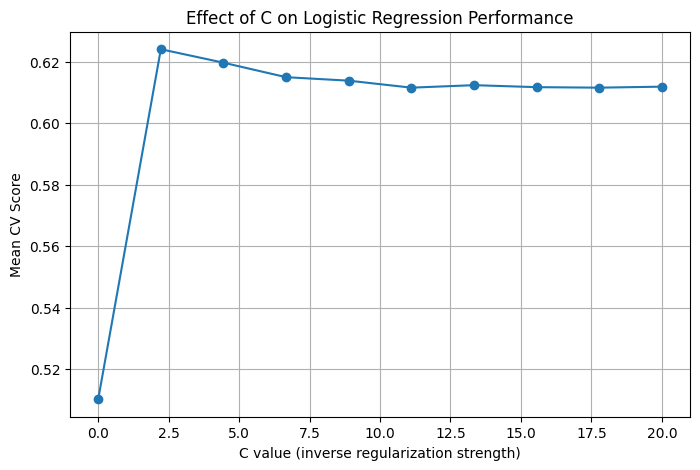

In [19]:
# Save cv results as a DataFrame
hyper_df = pd.DataFrame(grid.cv_results_)

plt.figure(figsize=(8,5))
plt.plot(hyper_df["param_model__C"], hyper_df["mean_test_score"], marker='o')
plt.xlabel("C value (inverse regularization strength)")
plt.ylabel("Mean CV Score")
plt.title("Effect of C on Logistic Regression Performance")
plt.grid(True)
plt.show()

In [20]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       786
           1       0.64      0.64      0.64       754

    accuracy                           0.65      1540
   macro avg       0.65      0.65      0.65      1540
weighted avg       0.65      0.65      0.65      1540



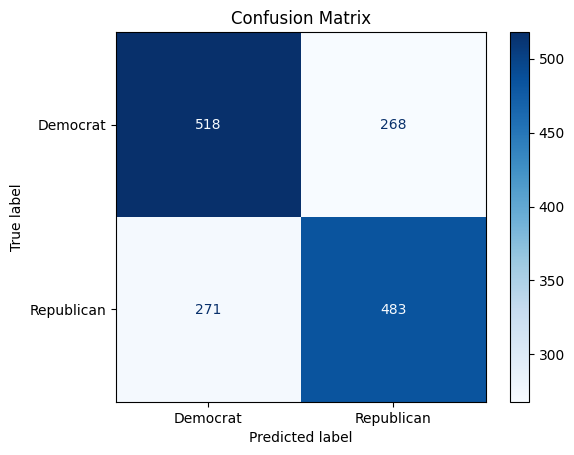

In [21]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Democrat', 'Republican'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()